# IA DATAHACK: soundcam
[Papier](https://proceedings.neurips.cc/paper_files/paper/2023/file/a4289154c9209b679ac761a50d5fec3a-Paper-Datasets_and_Benchmarks.pdf), [Site](https://sites.google.com/view/soundcam)

## Tâche: Localisation d'humains
Mettre au point un modèle de localisation de personne à partir d’audios
(RIRs).
Se baser sur la living room (pour limiter le nb de RAM à monter, éviter la
surcharge)

## Les attendus 
- Expérimenter et comparer différents algorithmes pour prédire la localisation d’une personne en utilisant les niveaux RMS (ou autre featurisation de leur choix) de 4 micros.
- Exploitation simultanée et de manière intégrée des channels pour une compréhension plus riche et plus complète (cf. VGGish multichannel dans le papier)
- BONUS : Etudier l’impact du nombre de micros sur les résultatss


## The dataset
Nous proposons une version tronquée du dataset pour faciliter le téléchargement et le traitement.
Les micros proposés sont: 1, 4, 6, 9 (par rapport aux 10 initiaux)

### Organisation du dataset

**Hierarchie**
Le jeu de données contient 3 sous-dossiers:
- Un dossier pour chaque humain dans le jeu de données
- Un dossier pour le *salon* vide

**Les fichiers**
Chaque sous-dossier contient:
- deconvolved.npy - les RIRs. Shape est [N_datapoints, 4, N_samples]
- centroid.npy - les x,y localisations des personnes dans la pièces. Shape est [N_datapoints, 2].
- skeletons.npy - the poses and joint locations as captured by each of the three cameras. The shape is [N_datapoints, N_Cameras, N_joints, 3]. The indexing of the joints is provided here.


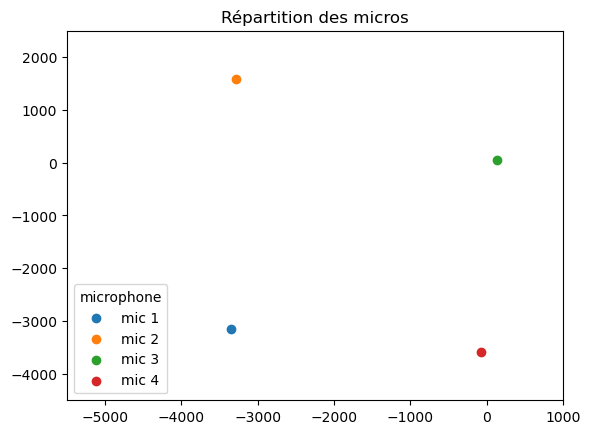

In [1]:

### disposition du salon (avec nombre de micros diminué)
import numpy as np
import matplotlib.pyplot as plt
# Microphone Locations
mic_height = 50.3125
feet = 12
y_tile = 23.5
x_tile = 11 +7/8

camera_origin_location = np.array([-6*x_tile-5.75, -y_tile, 45+13/16])*25.4

mic_1 = np.array([-11*x_tile - 1, -5*y_tile - 6-3/8, mic_height]) * 25.4 
mic_4= np.array([-11*x_tile + 1.25 + 1/16, 2.5*y_tile+3.75, mic_height]) * 25.4
mic_6 = np.array([5+3/8, 2+1/8, mic_height]) * 25.4
mic_9 = np.array([-3, -6*y_tile - 0.5, mic_height]) * 25.4


mic_xyzs = np.stack((mic_1,mic_4, mic_6, mic_9),axis=0)

SPEAKER_BOTTOM_RIGHT_Y = (1200.15 + 1196.975 + 1206.5)/ 3
SPEAKER_BOTTOM_RIGHT_X = (88.9 + 107.95 + 101.6) / 3
SPEAKER_BOTTOM_LEFT_Y = (1327.15 + 1311.55712764 + 1317.625) / 3
SPEAKER_BOTTOM_LEFT_X = - 76.98583188

speaker_xyz_bottom_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, 44.5*25.4])
speaker_xyz_bottom_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, 44.5*25.4])
speaker_xyz_top_right = np.array([SPEAKER_BOTTOM_RIGHT_X, SPEAKER_BOTTOM_RIGHT_Y, (44.5+17)*25.4])
speaker_xyz_top_left = np.array([SPEAKER_BOTTOM_LEFT_X, SPEAKER_BOTTOM_LEFT_Y, (44.5+17)*25.4])
speaker_xyz = (speaker_xyz_bottom_right+speaker_xyz_bottom_left+speaker_xyz_top_right+speaker_xyz_top_left)/4


walls = None
x_min = - 4000
x_max = 500
y_min = -4000
y_max = 2000


## affichier la disposition des microphones.
for idx, mic in enumerate(mic_xyzs):
    plt.scatter(mic[0], mic[1], label=f'mic {idx+1}')

plt.title("Répartition des micros")
plt.xlim([-5500, 1000])
plt.ylim([-4500, 2500])
plt.legend(loc="lower left", title="microphone")

RIR cam 1 measure 1:
(104, 4, 667200)


<Figure size 1000x400 with 0 Axes>

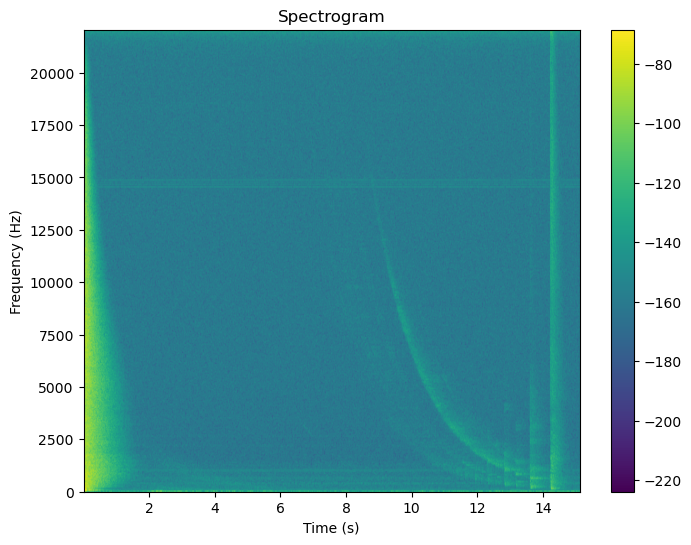

In [3]:
import os

DATASET_BASE_PATH = "data/LivingRoom_preprocessed_hack" #<---Use the path in your directory

DATASET_PATH = os.path.join(DATASET_BASE_PATH, "Human2") 

deconvoled = np.load(os.path.join(DATASET_PATH, "deconvoled_trim.npy"))
print("RIR cam 1 measure 1:")
print(deconvoled.shape)

plt.figure(figsize=(10, 4))

signal = deconvoled[0][1]
#plt.title(f"signal")
#plt.plot(signal)

#plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
spec, freq, t, im = ax.specgram(signal, NFFT=1024, Fs=44100, noverlap=900)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_title('Spectrogram')
plt.colorbar(im, ax=ax)
plt.show()

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import random

# Load the RIR data and labels for both human and empty room
human_rir_data = np.load('/home/onyxia/work/hackathon-acoustic-2024/data/LivingRoom_preprocessed_hack/Human2/deconvoled_trim.npy') 
human_rir_labels = np.load('/home/onyxia/work/hackathon-acoustic-2024/data/LivingRoom_preprocessed_hack/Human2/centroid.npy')
#empty_rir_data = np.load('/home/onyxia/work/hackathon-acoustic-2024/data/LivingRoom_preprocessed_hack/Empty/deconvolved.npy')

KeyboardInterrupt: 

In [6]:
#print(f"Shape of empty = {empty_rir_data.shape}")
print(f"Shape of centroids = {human_rir_labels.shape}")
print(f"Shape of deconvoled = {human_rir_data.shape}")

Shape of centroids = (104, 2)
Shape of deconvoled = (104, 4, 667200)


In [7]:
def rms(y):
    return np.sqrt(np.mean(y**2))


rms_levels = np.apply_along_axis(rms, axis=2, arr=human_rir_data)
# Check the shape of the resulting array
print(rms_levels.shape)
for i in range(10):
    print(f"RMS of RIR = {rms_levels[i]}")


(104, 4)
RMS of RIR = [0.00051895 0.00049993 0.00070688 0.00042812]
RMS of RIR = [0.00052196 0.00050171 0.00070162 0.00042788]
RMS of RIR = [0.00052073 0.00050171 0.00069957 0.00042877]
RMS of RIR = [0.00052132 0.0005012  0.00070112 0.00042895]
RMS of RIR = [0.00051945 0.00049751 0.00070292 0.00042582]
RMS of RIR = [0.00051981 0.00049912 0.00070256 0.00042964]
RMS of RIR = [0.00052275 0.00050204 0.00070195 0.0003721 ]
RMS of RIR = [0.00052406 0.00049996 0.00070456 0.00037091]
RMS of RIR = [0.00052132 0.00049877 0.00070122 0.00042658]
RMS of RIR = [0.00052173 0.00049787 0.00070082 0.00042716]


In [ ]:
for i in range(1):
    print(f"RIR = {human_rir_data[i]}")
    print(f"RMS of RIR = {rms(human_rir_labels[i])}")
    
print(f"-------------------------Centroids-------------------")
for i in range(1):
    print(f"Position = {human_rir_labels[i]}")
    

RIR = [[ 1.32263867e-05  4.04477396e-06  1.72964337e-05 ...  1.42459985e-05
   7.06920127e-06  1.52228458e-05]
 [ 1.66781626e-06  4.13932912e-06  4.92448726e-06 ...  1.69338909e-05
   1.40092038e-06  1.19383767e-05]
 [ 1.15825042e-05  4.49341405e-06  1.40825741e-05 ...  1.12802718e-05
   1.38609530e-05  6.46868511e-06]
 [-2.10553353e-05 -2.40086247e-05 -1.06697380e-05 ... -2.20970142e-05
  -2.00329578e-05 -2.09568789e-05]]
RMS of RIR = 2425.311298219079
-------------------------Centroids-------------------
Position = [-2406.85413008 -2443.62906004]


In [23]:
import numpy as np

def my_rolling_rms(y):
    # Calculate RMS for the first half of the array
    rms_first_half = np.sqrt(np.mean(y[:, :y.shape[1]//2]**2, axis=2))
    # Calculate RMS for the second half of the array
    rms_second_half = np.sqrt(np.mean(y[:, y.shape[1]//2:]**2, axis=2))
    # Concatenate the results
    #return np.concatenate((rms_first_half, rms_second_half), axis=2)
    return np.hstack((rms_first_half, rms_second_half))

# Calculate RMS levels for each sample along the last axis
rms_levels = my_rolling_rms(human_rir_data)






In [26]:
import numpy as np

def rms(y):
    # Compute the length of the array
    n = len(y)
    # Compute the index to split the array into halves
    split_index = n // 2
    # Compute RMS for the first half of the array
    rms_first_half = np.sqrt(np.mean(y[:split_index]**2))
    # Compute RMS for the second half of the array
    rms_second_half = np.sqrt(np.mean(y[split_index:]**2))
    # Concatenate the results horizontally
    return np.hstack((rms_first_half, rms_second_half))

# Calculate RMS levels for each sample along the last axis
rms_levels = np.apply_along_axis(rms, axis=2, arr=human_rir_data)


In [27]:
# Check the shape of the resulting array
print(rms_levels.shape)
# Print some example values
for i in range(10):
    print(f"RMS of RIR = {rms_levels[i]}")

(104, 4, 2)
RMS of RIR = [[0.55728967 0.56671712]
 [0.58297016 0.58121688]
 [0.58140719 0.57794264]
 [0.58521758 0.58745465]]
RMS of RIR = [[0.60203978 0.58613059]
 [0.56312672 0.58600112]
 [0.58638557 0.56354278]
 [0.5810948  0.56548691]]
RMS of RIR = [[0.58241797 0.56242584]
 [0.58842145 0.5853724 ]
 [0.57854903 0.5991594 ]
 [0.5828412  0.58480149]]
RMS of RIR = [[0.57821077 0.59316892]
 [0.58395996 0.57516481]
 [0.57560091 0.57699726]
 [0.59679976 0.56757723]]
RMS of RIR = [[0.56361745 0.56877746]
 [0.59286729 0.57479638]
 [0.57715788 0.58363465]
 [0.59053516 0.55421575]]
RMS of RIR = [[0.5671672  0.56557205]
 [0.57893692 0.5711201 ]
 [0.58536459 0.56923653]
 [0.57178851 0.59300243]]
RMS of RIR = [[0.58619906 0.58975743]
 [0.5831247  0.56854871]
 [0.58262189 0.57435682]
 [0.56803471 0.57585356]]
RMS of RIR = [[0.57042432 0.57742097]
 [0.57512069 0.6016421 ]
 [0.58072668 0.58959627]
 [0.5809284  0.57217834]]
RMS of RIR = [[0.5950623  0.57125142]
 [0.59553652 0.57695456]
 [0.59062117 

In [31]:
rir_labels = human_rir_labels
# Normalize the RMS levels
rms_levels_norm = (rms_levels - np.mean(rms_levels, axis=0)) / np.std(rms_levels, axis=0)

print(rir_labels[1])
print(rir_labels[2])
print(rms_levels_norm[1])
print(rms_levels_norm[2])
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(rms_levels_norm, rir_labels, test_size=0.2, random_state=42)

""" # Train a linear regression model for each coordinate separately 
regressor_x = LinearRegression()
print("model is fitting for x coordinates")
regressor_x.fit(X_train, y_train[:, 0])  # Train for x-coordinate

regressor_y = LinearRegression()
print("model is fitting for y coordinates")
regressor_y.fit(X_train, y_train[:, 1])  # Train for y-coordinate """
# Reshape the RMS levels data to have the correct shape
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Train a linear regression model for each coordinate separately 
regressor_x = LinearRegression()
print("model is fitting for x coordinates")
regressor_x.fit(X_train_reshaped, y_train[:, 0])  # Train for x-coordinate

regressor_y = LinearRegression()
print("model is fitting for y coordinates")
regressor_y.fit(X_train_reshaped, y_train[:, 1])  # Train for y-coordinate

# Reshape X_test to have only two dimensions
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Make predictions on test set
y_pred_x = regressor_x.predict(X_test_reshaped)
y_pred_y = regressor_y.predict(X_test_reshaped)


# Select 10 random indices from the test set
random_indices = random.sample(range(len(y_test)), 10)

# Combine x and y predictions into coordinates
y_pred = np.column_stack((y_pred_x, y_pred_y))

# Print the predicted and true positions for the selected indices
print("Randomly Selected Predictions:")
for idx in random_indices:
    true_pos = y_test[idx]
    pred_pos = y_pred[idx]
    print(f"Index {idx}: True Position = {true_pos}, Predicted Position = {pred_pos}")

# Calculate Euclidean distance between predicted and actual coordinates
errors = np.sqrt(np.sum((y_pred - y_test)**2, axis=1))
mean_error = np.mean(errors)
print(f'\nMean localization error: {mean_error:.3f} cm')

[-1923.16230038 -2504.30576997]
[-1615.29307549 -2525.71107555]
[[ 2.21200352  0.71000443]
 [-1.29659256  0.58490423]
 [ 0.80729306 -1.02544582]
 [ 0.43500177 -1.02618182]]
[[ 0.53168616 -1.34995107]
 [ 0.95633495  0.52434978]
 [ 0.07532421  1.99885058]
 [ 0.59994231  0.7685653 ]]
model is fitting for x coordinates
model is fitting for y coordinates
Randomly Selected Predictions:
Index 12: True Position = [-2978.56597766  -269.83433736], Predicted Position = [-2309.65740781  -574.99841061]
Index 17: True Position = [-2734.10489942 -1134.21199905], Predicted Position = [-2568.37017965  -724.25090787]
Index 10: True Position = [-3818.97939345 -2074.06640841], Predicted Position = [-2196.69044765  -740.54338678]
Index 0: True Position = [-3651.45722762 -1008.85761266], Predicted Position = [-2495.36156462  -683.03608656]
Index 1: True Position = [-2118.32611622  -608.1245535 ], Predicted Position = [-1983.80485829  -764.35038927]
Index 4: True Position = [ -332.36265002 -1022.65309523], P